In [1]:
# import relevant libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import asyncio as aio
import bleak as ble

# turn on certain matplotlib backends
%matplotlib inline
#%matplotlib widget

In [93]:
async def discover_devices():
    print("Scanning for Bluetooth devices...")
    # discover devices
    devices = await ble.BleakScanner.discover()
    for device in devices:
        if device.name is not None:
            print(f"Device: {device.name} ({device.address})")
        
await discover_devices()

Scanning for Bluetooth devices...
Device: LE_WH-1000XM5 (010E03B4-F160-154D-DD43-BD156E9EA731)
Device: MY_APP (15CA291A-FF53-3033-4BC8-5375134A3843)
Device: tomg’s iPad (963A3116-71AD-E737-6F3F-0F4525860AF0)
Device: LE-Warriors 2 (726B1821-0BA5-AA1E-70C4-D61129A0716C)
Device: LE_WH-1000XM4 (33F80E47-FD6C-6B95-A1C2-C30D3974A3C1)


In [137]:
device_address    = "15CA291A-FF53-3033-4BC8-5375134A3843"

#"4F8961AD-96AA-2979-CA6F-FBEE3CAC6F67"

async def connect_device(device_address):
    print(f"Connecting to device at {device_address}...")
    client  = ble.BleakClient(device_address)
    try:
        await client.connect()
        if client.is_connected:
            print(f"Successfully connected to {device_address}.")
            print("Listing available services and characteristics:")
            
            # List all services and their characteristics
            for service in client.services:
                print(f"Service: {service.uuid}")
                for characteristic in service.characteristics:
                    print(f"  Characteristic: {characteristic.uuid} | Properties: {characteristic.properties}")
            return client  # Return the client pointer for further use
        else:
            print(f"Failed to connect to {device_address}.")
            return None
    except Exception as e:
        print(f"An error occurred while connecting: {e}")
        return None
    

client      = await connect_device(device_address)
if client:
    # Perform operations with the connected client
    print("Client is ready for further operations.")
    
    # Example: List services
    for service in client.services:
        print(f"Service: {service.uuid}")
else:
    print("Could not connect to the device.")

Connecting to device at 15CA291A-FF53-3033-4BC8-5375134A3843...
Successfully connected to 15CA291A-FF53-3033-4BC8-5375134A3843.
Listing available services and characteristics:
Service: 00000000-cc7a-482a-984a-7f2ed5b3e58f
  Characteristic: 0000fe41-8e22-4541-9d4c-21edae82ed19 | Properties: ['read', 'write-without-response']
  Characteristic: 0000fe42-8e22-4541-9d4c-21edae82ed19 | Properties: ['notify', 'indicate']
Client is ready for further operations.
Service: 00000000-cc7a-482a-984a-7f2ed5b3e58f


In [138]:
audio_data = np.array([], dtype=np.int16)

def notification_handler(sender, data):
    global audio_data
    print(f"Notification from {sender}: {data}")
    
    new_data = np.frombuffer(data, dtype="<i1")
    audio_data = np.append(audio_data, new_data)


async def subscribe_to_notifications(client, characteristic_uuid):
    if client.is_connected:
        print(f"Subscribing to notifications for characteristic {characteristic_uuid}...")
        try:
            # Start notifications
            await client.start_notify(characteristic_uuid, notification_handler)
            #print("Subscribed! Waiting for notifications...")
            
            # Keep the connection alive to receive notifications
            await aio.sleep(5)  # Adjust the duration as needed
            
            # Stop notifications
            print("Stopping notifications...")
            await client.stop_notify(characteristic_uuid)
        except Exception as e:
            print(f"Failed to subscribe to notifications: {e}")
    else:
        print("Client is not connected.")

# Example usage
characteristic_uuid = "0000fe42-8e22-4541-9d4c-21edae82ed19"  # Replace with the notification characteristic UUID
await subscribe_to_notifications(client, characteristic_uuid)

Subscribing to notifications for characteristic 0000fe42-8e22-4541-9d4c-21edae82ed19...
Notification from 0000fe42-8e22-4541-9d4c-21edae82ed19 (Handle: 15): Nets A/S: bytearray(b'\x00\x00\x05\xfc\xf8\xff\x0e\xe4\x11\x06\x04\x00\xff\xf3\xee\xe9\xf6\t\xfa\xff\r\x0f\xfd\xf8\x02\t\x00\xf3\xfc\x01\xf1\xfd\xfe\xfc\xef\x04\x08\x04\x05\n\x03\x06\xfd\xfb\xf5\xf2\x18\n\x05\x15\x0b\xf5\xe9\x00\x04\xed\x14\xe9\xff\x02\xf8\xfe\x11\xfc\x03\xfa\xf9\xf4\xfd\x08\x06\x02\xf9\x04\x00\xff\xfb\x02\n\x08\x08\xf9\x0e\xf9\xe3\n\xfe\t\x1e\x08\x05\x14\x02\x08\x08\xfb\xf4\x08\xea\x02\t\x0b\x00\x03\xf3\xf4\xff\xf0\x05\xfd\n\x14\xfb\xf3\xd8\x07\xe8\x08\xf4\x04\xf1\t\x00\n\t\xee\xf9\xf6')
Notification from 0000fe42-8e22-4541-9d4c-21edae82ed19 (Handle: 15): Nets A/S: bytearray(b'\x0f\xf7\xfb\x01\x14\xfa\x03\x16\xf4\x02\xfc\xf5\xfc\xfb\xf5\x01\xf2\t\xf7\x08\x01\xed\xf6\xf3\xeb\xf6\xfe\t\xff\x16\xea\x07\x12\x03\x02\xe8\x06\xf7\x11\xf8\xf9\xfa\xf9\xfd\n\xfe\x00\x11\xf0\xfb\n\x08\xfc\xfd\x02\x08\xf0\xfc\x07\xfc\x07\xff\

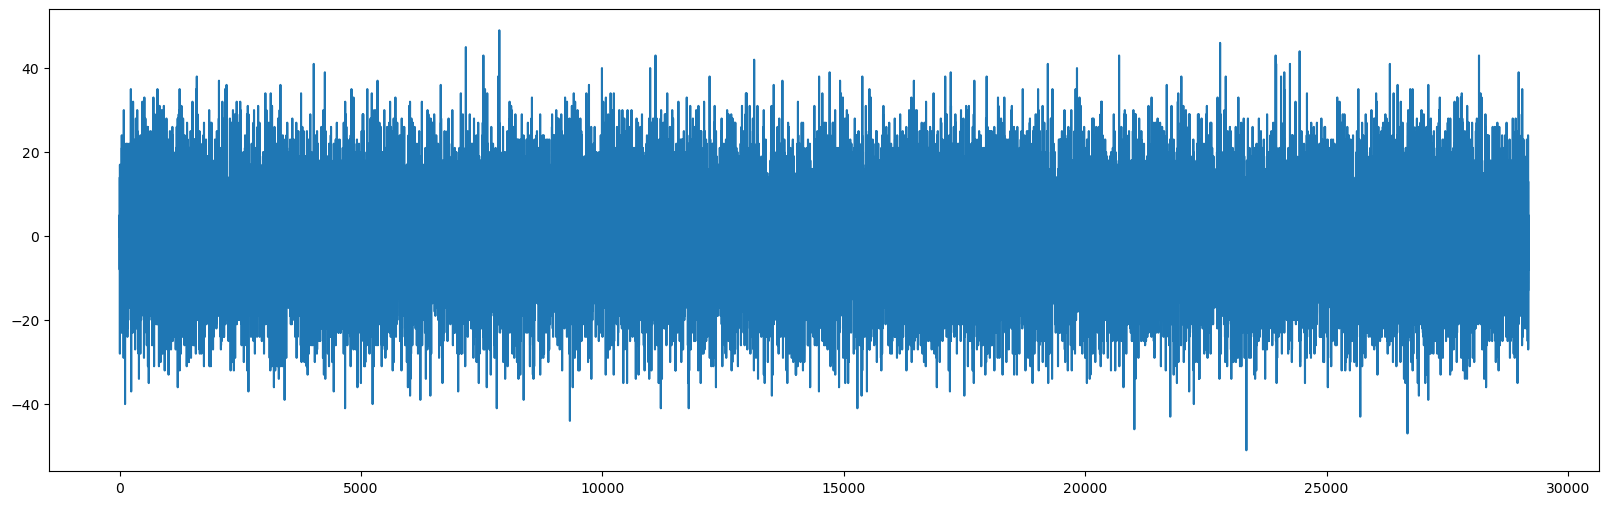

[]

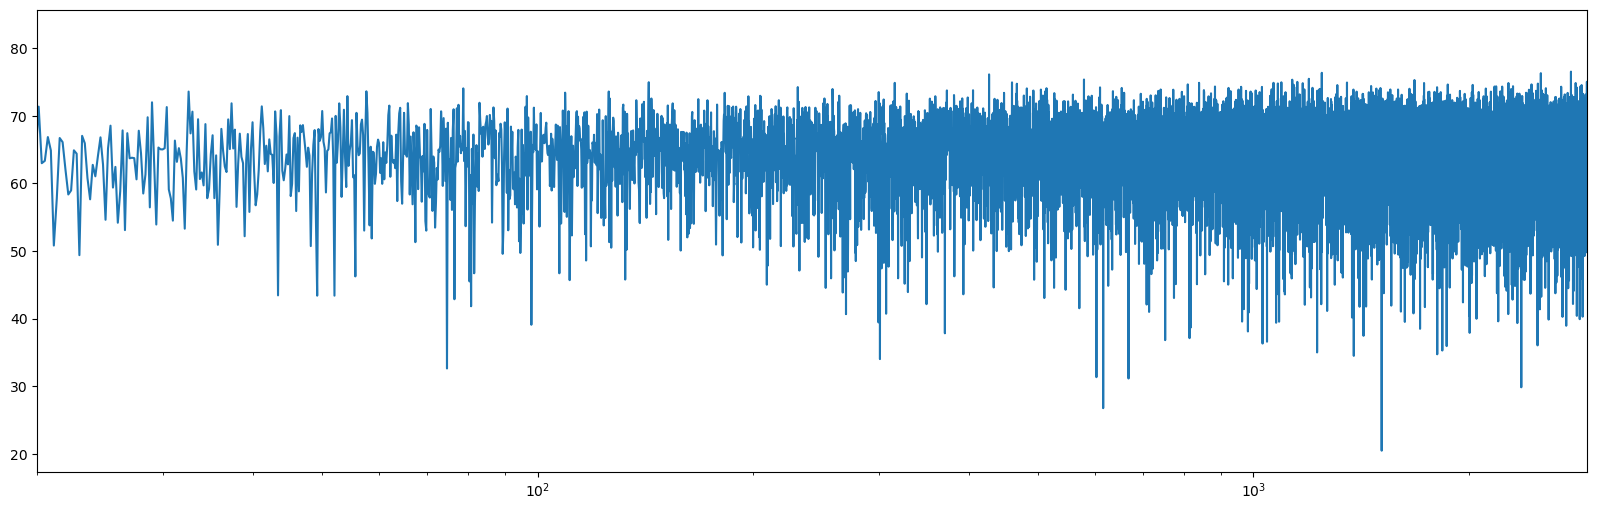

In [139]:
fs = 11718.75/2

b, a, = sp.signal.butter(3, 1000, fs=fs)
b, a = sp.signal.iirnotch(289.22872340425533, 1.404, fs)
filtered_audio = sp.signal.lfilter(b, a, audio_data)
plt.figure(figsize=(20,6))
plt.plot(audio_data)
plt.show()

audio_fft = np.fft.rfft(audio_data)

plt.figure(figsize=(20, 6))
plt.plot(np.fft.rfftfreq(len(filtered_audio))*fs, 20*np.log10(np.abs(audio_fft)))
plt.xscale("log")
plt.xlim(20, fs/2)
plt.plot()

In [140]:
from IPython.display import Audio

def play_audio_in_notebook(audio_data, sample_rate=44100):
    """
    Play audio from a numpy array in a Jupyter Notebook.
    
    Parameters:
    - audio_data: numpy array containing audio samples
    - sample_rate: Sampling rate of the audio (default: 44100 Hz)
    """
    if len(audio_data) == 0:
        print("Audio data is empty. Nothing to play.")
        return
    
    print(f"Playing audio with {len(audio_data)} samples at {sample_rate} Hz...")
    return Audio(audio_data, rate=sample_rate)

# Example usage
# Assuming `audio_data` is a numpy array containing audio samples
# Replace `audio_data` with your actual numpy array
play_audio_in_notebook(audio_data_fixed, sample_rate=fs)

Playing audio with 29184 samples at 5859.375 Hz...


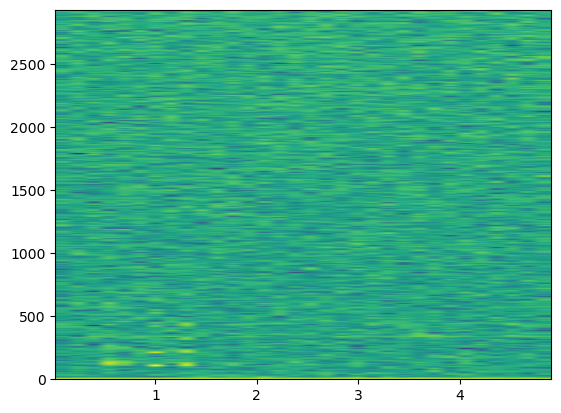

In [133]:
import matplotlib.pyplot as plt
import numpy as np


NFFT = 1024  # the length of the windowing segments

Pxx, freqs, bins, im = plt.specgram(audio_data, NFFT=NFFT, Fs=fs)
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the .image.AxesImage instance representing the data in the plot


plt.show()